Testing to make sure that the convolve operation is correct. 

In [53]:
%matplotlib inline
%connect_info
%load_ext Cython
%load_ext autoreload
%autoreload 2  # 0 disable, 1 for only %aimport objects, 2 for those EXCEPT %aimport

# numpy and matplotlib already imported
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import fitsio
import pandas as pd
from subprocess import check_output
#from DeconvolvePSF.lucy import convolve
from DeconvolvePSF.lucy import deconvolve
from scipy.signal import convolve2d as convolve

import ipywidgets
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
py.sign_in("cpadavis", "4oa3kd6g16")

{
  "stdin_port": 46122, 
  "ip": "127.0.0.1", 
  "control_port": 41418, 
  "hb_port": 39431, 
  "signature_scheme": "hmac-sha256", 
  "key": "1f9486df-e123-4229-9431-40f2ccb17ddd", 
  "shell_port": 48416, 
  "transport": "tcp", 
  "iopub_port": 47707
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /afs/slac.stanford.edu/u/ki/swmclau2/.local/share/jupyter/runtime/kernel-25984411-1d7d-4c83-82ad-1e84f81dfb90.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
kils = True

# these give the deconvolved stars
out_base = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/'

In [55]:
sample_num = 5000

dir_str = check_output('ls -d %s*/'%out_base, shell = True) #get all the directories in our output dir
dir_list = dir_str.split('/\n')[:-1]#skip the lsat one, its ''

expids = [int(direc.lstrip('%s'%out_base) ) for direc in dir_list]
expids = sorted(expids)
bad_expid_idxs = [2,5, 6]
#14
expid = expids[20]
#expid = 179966
print(expid)

if kils:
    # these give the deconvolved stars
    out_base = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/'
    #out_base = '/nfs/slac/g/ki/ki18/des/cpd/DeconvOutput/'
    deconv_dir = out_base + '{0:08d}'.format(expid)
    # not sure what stars these really are? the combined psfex + deconv?
    deconvmodel_loc = out_base + '{0:08d}/{0}_stars.npy'.format(expid)
    deconvopt_loc = out_base + '{0:08d}/{0}_opt.npy'.format(expid)
    deconvatm_loc = out_base + '{0:08d}/{0}_atm.npy'.format(expid)
    deconvstarsminusopt_loc = out_base + '{0:08d}/{0}_stars_minus_opt.npy'.format(expid)
    deconvdata_loc = out_base + '{0:08d}/{0}_data.npy'.format(expid)
    deconvpsfex_loc = out_base + '{0:08d}/{0}_psfexalone.npy'.format(expid)
    deconvdf_loc = out_base + '{0:08d}/results.h5'.format(expid)
    deconvdf_key = 'table_{0:08d}'.format(expid)
    
    deconvopt_immediate_loc = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/{0:08d}/{0}_opt_test.npy'.format(expid)
    
    jamierod_results_path = '/nfs/slac/g/ki/ki18/des/cpd/jamierod_results.csv'
    mesh_directory = '/nfs/slac/g/ki/ki22/roodman/ComboMeshesv20'
    # directory containing the input data files
    base_directory = '/nfs/slac/g/ki/ki18/des/cpd/psfex_catalogs/SVA1_FINALCUT/psfcat/'
else:
    # these give the deconvolved stars
#     deconv_dir = '/Users/cpd/Desktop/deconvpsf/00180000/00180489/'
    # not sure what stars these really are? the combined psfex + deconv?
#     deconvmodel_loc = '/Users/cpd/Desktop/deconvpsf/00180000/00180489/180489_stars.npy'
    jamierod_results_path = '/Users/cpd/Desktop/deconvpsf/jamierod_results.csv'
    mesh_directory = '/Users/cpd/Projects/WavefrontPSF/meshes/Science-20121120s1-v20i2'
    # directory containing the input data files
    base_directory = '/Users/cpd/Desktop/deconvpsf'

from WavefrontPSF.psf_interpolator import Mesh_Interpolator
from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.digestor import Digestor
from WavefrontPSF.psf_evaluator import Moment_Evaluator
from WavefrontPSF.donutengine import DECAM_Model_Wavefront
from glob import glob
from itertools import izip
from psfex import PSFEx
combinekeys = ['e0', 'e1', 'e2', 'E1norm', 'E2norm', 'delta1', 'delta2', 'zeta1', 'zeta2']
names = ['model', 'psfex', 'starminusopt', 'opt', 'atm', 'reconv', 'opt2']
#names = ['']
diff_names = ['model', 'psfex']
#diff_names = ['']

157930


# skeleton for making psf model

# this gets you a bunch of stamps

In [56]:
def evaluate_stamps_and_combine_with_data(stamps, data):
    eval_data = WF.evaluate_psf(stamps)
    eval_data.index = data.index
    print(data.index)
    combined_df = eval_data.combine_first(data)
    return combined_df

In [57]:
#Look I'm a comment this isn't rawnb
atmpsf = np.load(deconvatm_loc)
optpsf = np.load(deconvopt_loc)
starminusopt = np.load(deconvstarsminusopt_loc)
model = np.load(deconvmodel_loc)
psfexpsf = np.load(deconvpsfex_loc)
stars = np.load(deconvdata_loc)

df = pd.read_hdf(deconvdf_loc, deconvdf_key)

In [58]:
reconvpsf = np.zeros((optpsf.shape[0], 32,32))
for idx, (opt, resid) in enumerate(izip(optpsf, starminusopt)):
    reconvpsf[idx] = convolve(opt, resid, mode = 'same')
#reconvpsf = convolve(optpsf, starminusopt[:, 15:47, 15:47])

In [59]:
reconvpsf_df = evaluate_stamps_and_combine_with_data(reconvpsf, df)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            33, 34, 35, 36, 37, 38, 39, 40, 41, 42],
           dtype='int64', length=1943)


In [60]:
opt2psf = np.zeros((optpsf.shape[0], 32,32))
for idx, (mod, atm) in enumerate(izip(model, atmpsf)):
    opt2psf[idx] = deconvolve(atm, mod,psi_0=None,mask=None,mu0=6e3,convergence=1e-3,chi2Level=0.,niterations=50, extra= False)
#reconvpsf = convolve(optpsf, starminusopt[:, 15:47, 15:47])

In [61]:
opt2psf_df = evaluate_stamps_and_combine_with_data(opt2psf, df)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            33, 34, 35, 36, 37, 38, 39, 40, 41, 42],
           dtype='int64', length=1943)


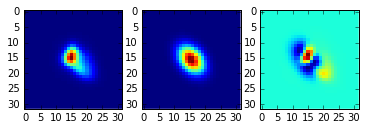

In [62]:
opt_diff = optpsf-opt2psf
idx = 0
gmin, gmax = 1, -1
plt.subplot(131)
plt.imshow(optpsf[idx], interpolation = 'None')
gmin = optpsf[idx].min()
gmax = optpsf[idx].max()
plt.subplot(132)
plt.imshow(opt2psf[idx], interpolation = 'None')
gmin = opt2psf[idx].min() if opt2psf[idx].min() < gmin else gmin
gmax = opt2psf[idx].max() if opt2psf[idx].max() > gmax else gmax
plt.subplot(133)
plt.imshow(opt_diff[idx], interpolation = 'None')
gmin = opt_diff[idx].min() if opt_diff[idx].min() < gmin else gmin
gmax = opt_diff[idx].max() if opt_diff[idx].max() > gmax else gmax
#plt.colorbar()

In [63]:
new_names = ['reconv', 'opt2']
new_df_list = [reconvpsf_df, opt2psf_df]
#TODO this shouldn't be a list of one, just how it turned out
for key in combinekeys:
   
    for name, psf in izip(new_names, new_df_list):
        if key == 'E1norm':
            psf[key] = psf['e1'] / psf['e0']
        elif key == 'E2norm':
            psf[key] = psf['e2'] / psf['e0']
        df['{0}_{1}'.format(name, key)] = psf[key]
        # add medsub
        df['{0}_{1}_medsub'.format(name, key)] = df['{0}_{1}'.format(name, key)] - df['{0}_{1}'.format(name, key)].median()
        df['{0}_{1}_diff'.format(name, key)] = df['{0}_{1}'.format(name, key)] - df[key]
        df['{0}_{1}_medsub_diff'.format(name, key)] = df['{0}_{1}_medsub'.format(name, key)] - df['{0}_medsub'.format(key)]
df = df.copy()

In [64]:
# can play with this value to make the binning more or less fine
# add psfex model diff
for key in combinekeys:
    name1 = 'model'
    name2 = 'psfex'
    df['{0}_{1}_{2}_diff'.format(name1, name2, key)] = df['{0}_{1}'.format(name1, key)] - df['{0}_{1}'.format(name2, key)]
    df['{0}_{1}_{2}_medsub_diff'.format(name1, name2, key)] = df['{0}_{1}_medsub'.format(name1, key)] - df['{0}_{1}_medsub'.format(name2, key)]
    #add some of my own
    
df_in = df.copy()

# df_in = df_in[df_in['SNR_WIN'] > 50]

if len(df_in) < 1000:
    num_bins = 0
    num_bins_cmap = 3
elif len(df_in) < 10000:
    num_bins = 1
    num_bins_cmap = 3
elif len(df_in) < 50000:
    num_bins = 2
    num_bins_cmap = 4
elif len(df_in) < 100000:
    num_bins = 3
    num_bins_cmap = 8
elif len(df_in) < 150000:
    num_bins = 4
    num_bins_cmap = 16
else:
    num_bins = 5
    num_bins_cmap = 32
print(len(df_in), num_bins, num_bins_cmap)
WF = Wavefront(model=df_in, num_bins=num_bins)

1943 1 3


# plot the wavefronts in terms of the moments for the different models

<function __main__.plot_wavefront>

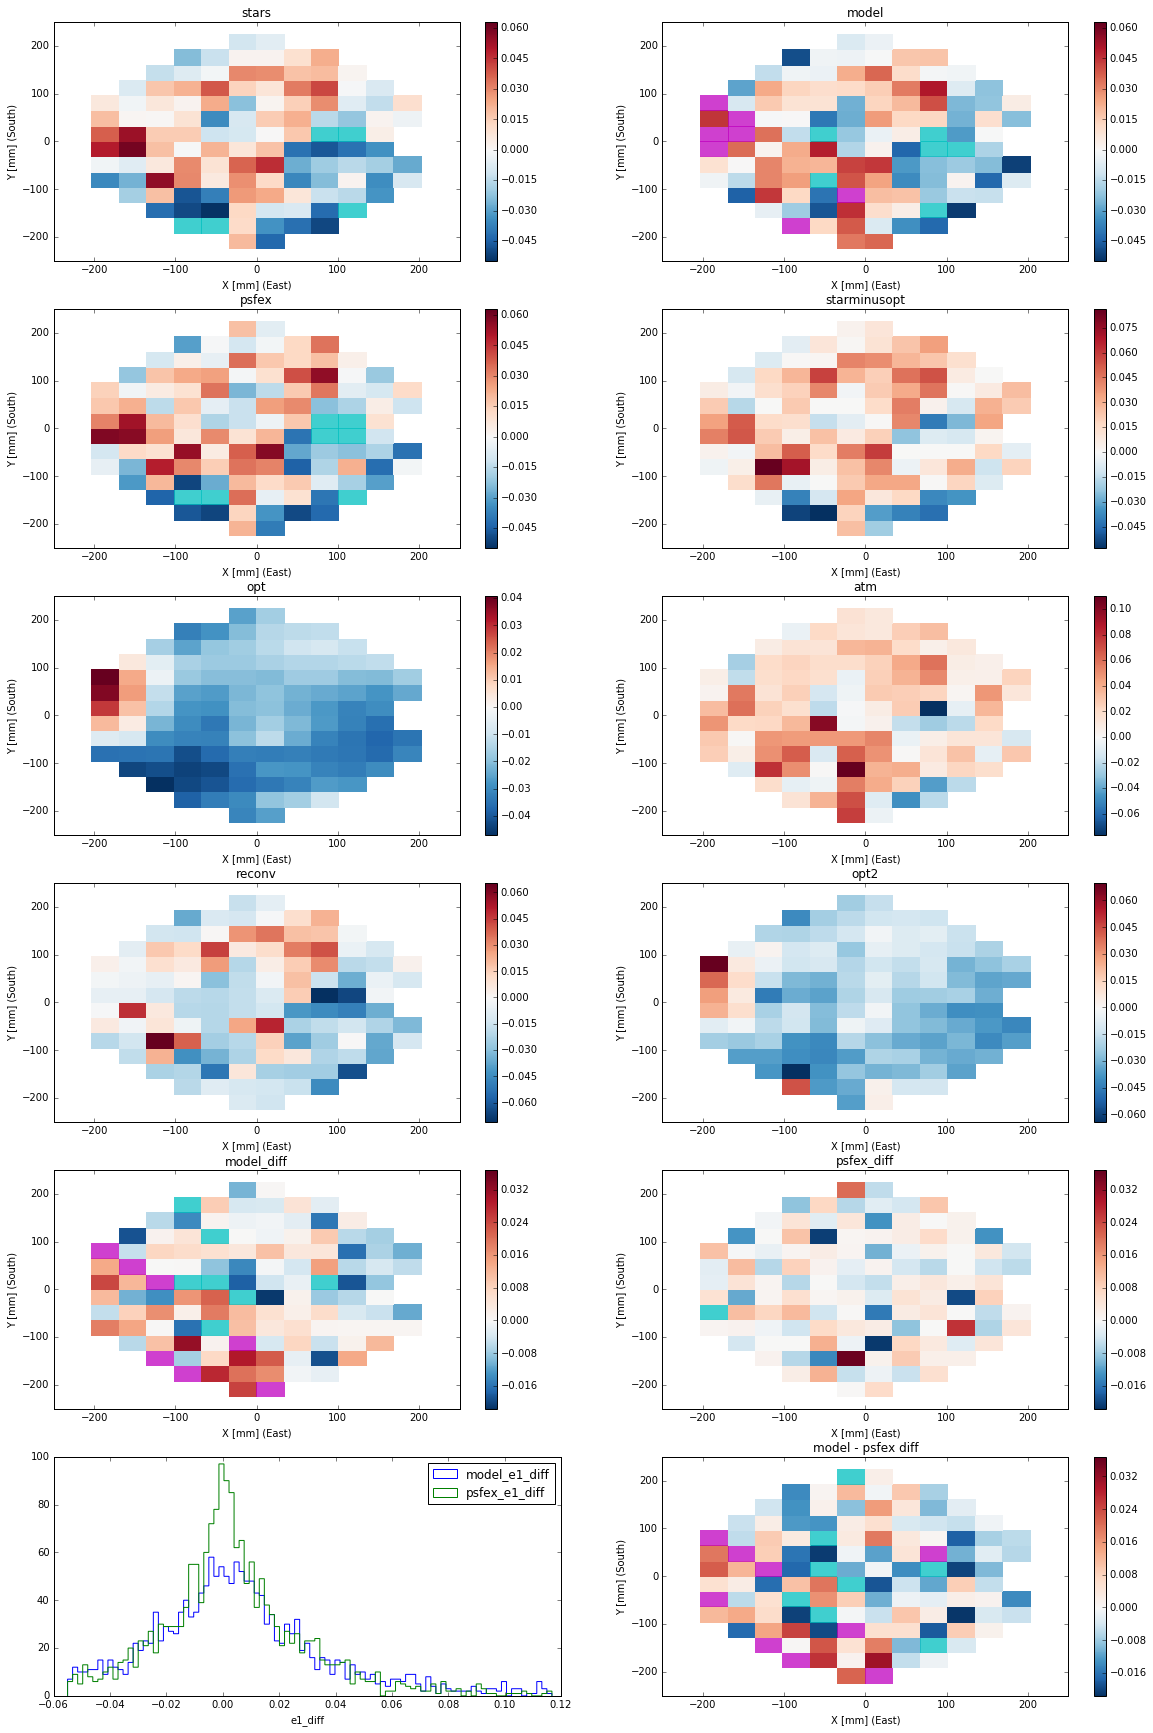

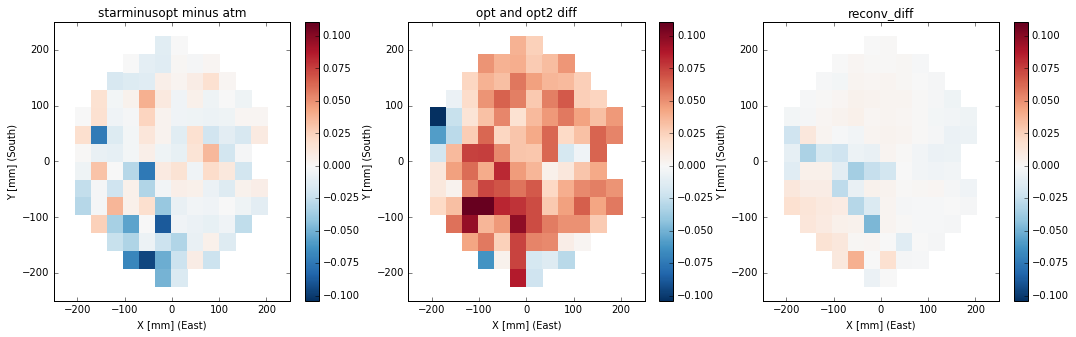

In [65]:
def plot_wavefront(key='e1', ccd=0):
    
    if ccd > 0:
        field = WF.data[WF.data['ext'] == ccd]
    else:
        field = WF.field
    # set a and b vmin and vmax
    cutoff_percent = 5
#     mins = [np.percentile(field[key], cutoff_percent)] + \
    mins = \
           [np.percentile(field['{0}_{1}'.format(name, key)], cutoff_percent) for name in diff_names]
#     maxs = [np.percentile(field[key], 100 - cutoff_percent)] + \
    maxs = \
           [np.percentile(field['{0}_{1}'.format(name, key)], 100 - cutoff_percent) for name in diff_names]
    a = min(mins)
    b = max(maxs)
    
    nrows = int(np.ceil((len(names) + 1) / 2)) + len(diff_names)
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
    ax = axs.flatten()[0]
    if ccd == 0:
        ax = WF.prep_axis(ax)
        WF.plot_field(key,
                      field=field,
                      fig=fig, ax=ax, a=a, b=b)
    else:
        WF.plot_colormap(field, xkey='XWIN_IMAGE', ykey='YWIN_IMAGE',
                         zkey='{0}_{1}'.format(name, key),
                         num_bins=num_bins_cmap, b=b, a=a,
                         fig=fig, ax=ax)
    ax.set_title('stars')
    for name_i, name in enumerate(names, start=1):
        if name in diff_names:
            a_use = a
            b_use = b
        else:
            a_use = 0
            b_use = 0
        ax = axs.flatten()[name_i]
        if ccd == 0:
            ax = WF.prep_axis(ax)
            WF.plot_field('{0}_{1}'.format(name, key),
                          field=field,
                          fig=fig, ax=ax, a=a_use, b=b_use)
        else:
            WF.plot_colormap(field, xkey='XWIN_IMAGE', ykey='YWIN_IMAGE',
                             zkey='{0}_{1}'.format(name, key),
                             num_bins=num_bins_cmap, b=b_use, a=a_use,
                             fig=fig, ax=ax)
        ax.set_title(name)
        
    
    cutoff_percent_diff = 5
    mins_diff = [np.percentile(field['{0}_{1}_diff'.format(name, key)], cutoff_percent_diff) for name in diff_names]
    maxs_diff = [np.percentile(field['{0}_{1}_diff'.format(name, key)], 100 - cutoff_percent_diff) for name in diff_names]
    a_diff = min(mins_diff)
    b_diff = max(maxs_diff)
    
    mins_diff = [np.percentile(field['{0}_{1}_diff'.format(name, key)], 0) for name in diff_names]
    maxs_diff = [np.percentile(field['{0}_{1}_diff'.format(name, key)], 100) for name in diff_names]
    a_diff_bins = min(mins_diff)
    b_diff_bins = max(maxs_diff)
    
    diff_start = len(names) + (len(names) + 1) % 2 + 1
    
    ax_hist = axs.flatten()[diff_start + len(diff_names)]
    diff_bins = np.linspace(a_diff_bins, b_diff_bins, int(len(WF.data) / 20))
    for name_i, name in enumerate(diff_names):
        diff_key = '{0}_{1}_diff'.format(name, key)
        ax = axs.flatten()[diff_start + name_i]
        if ccd == 0:
            ax = WF.prep_axis(ax)
            WF.plot_field(diff_key,
                          field=field,
                          fig=fig, ax=ax,
                          a=a_diff, b=b_diff,
                         )
        else:
            WF.plot_colormap(field, xkey='XWIN_IMAGE', ykey='YWIN_IMAGE',
                             zkey=diff_key,
                             num_bins=num_bins_cmap, b=b_diff, a=a_diff,
                             fig=fig, ax=ax)
        
        ax.set_title(name + '_diff')
        
        ax_hist.hist(WF.data[diff_key], bins=diff_bins, histtype='step', label=diff_key)
        ax_hist.set_xlabel('{0}_diff'.format(key))
    ax_hist.legend()
    
    # have an extra!
#     axs.flatten()[1].set_axis_off()
    if (len(names) + 1) % 2 != 0:
        axs.flatten()[1 + len(names) + len(names) % 2].set_axis_off()
        
#     if (len(diff_names) + 1) % 2 != 0:
#         axs.flatten()[diff_start + len(diff_names) + 1].set_axis_off()
    # throw in model - psfex
    ax = axs.flatten()[-1]
    diff_key = '{0}_{1}_{2}_diff'.format('model', 'psfex', key)
    if ccd == 0:
        ax = WF.prep_axis(ax)
        WF.plot_field(diff_key,
                      field=field,
                      fig=fig, ax=ax,
                      a=a_diff, b=b_diff,
                     )
    else:
        WF.plot_colormap(field, xkey='XWIN_IMAGE', ykey='YWIN_IMAGE',
                         zkey=diff_key,
                         num_bins=num_bins_cmap, b=b_diff, a=a_diff,
                         fig=fig, ax=ax)
    ax.set_title('model - psfex diff')
    
    
    # temp looking at the deconv process
    temp_names = []
    temp_name = 'starminusopt minus atm'
    temp_names.append(temp_name)
    WF.field[temp_name] = WF.field['{0}_{1}'.format('starminusopt', key)] - WF.field['{0}_{1}'.format('atm', key)]
    temp_name = 'opt and opt2 diff'
    temp_names.append(temp_name)
    WF.field[temp_name] = WF.field['{0}'.format(key)] - WF.field['{0}_{1}'.format('opt', key)] - WF.field['{0}_{1}'.format('opt2', key)]
    temp_name = 'reconv_diff'
    temp_names.append(temp_name)
    WF.field[temp_name] = WF.field['{0}_{1}_diff'.format('reconv', key)]
    a = np.min([WF.field[asdf] for asdf in temp_names])
    b = np.max([WF.field[asdf] for asdf in temp_names])
    fig, axs = plt.subplots(ncols=len(temp_names), figsize=(6*len(temp_names), 5))
    for name_i, name, in enumerate(temp_names):
        ax = axs.flatten()[name_i]
        ax = WF.prep_axis(ax)
        WF.plot_field(name, field=WF.field, fig=fig, ax=ax, a=a, b=b)
        ax.set_title(name)
    
ipywidgets.interact(plot_wavefront,
                    key=combinekeys + [key + '_medsub' for key in combinekeys],
                    ccd=(0, 63, 1))

In [66]:
def separate_negative_and_positive_corr(xi):
    # useful for plotting on loglog scale.
    # NOTE: every neg gets an additional point of overlap. This makes plotting
    # much easier!
    xi_neg = np.ma.masked_where(xi >= 0, np.abs(xi))
    # catch the case where all objects are -ve or +ve
    mask = xi_neg.mask.copy()
    if np.all(xi < 0):
        mask = np.array([False] * len(xi))
        xi_neg.mask = mask
    elif np.all(xi >= 0):
        mask = np.array([True] * len(xi))
        xi_neg.mask = mask
    # now for every False index in mask,
    # set the indices immediately before and after False
    for xi_neg_indx in range(len(xi_neg)):
        if not mask[xi_neg_indx]:
            if xi_neg_indx != 0:
                xi_neg.mask[xi_neg_indx - 1] = False
            if xi_neg_indx != len(xi_neg) - 1:
                xi_neg.mask[xi_neg_indx + 1] = False
    xi_pos = xi_neg.copy()
    xi_pos.mask = ~mask
    
    return xi_pos, xi_neg

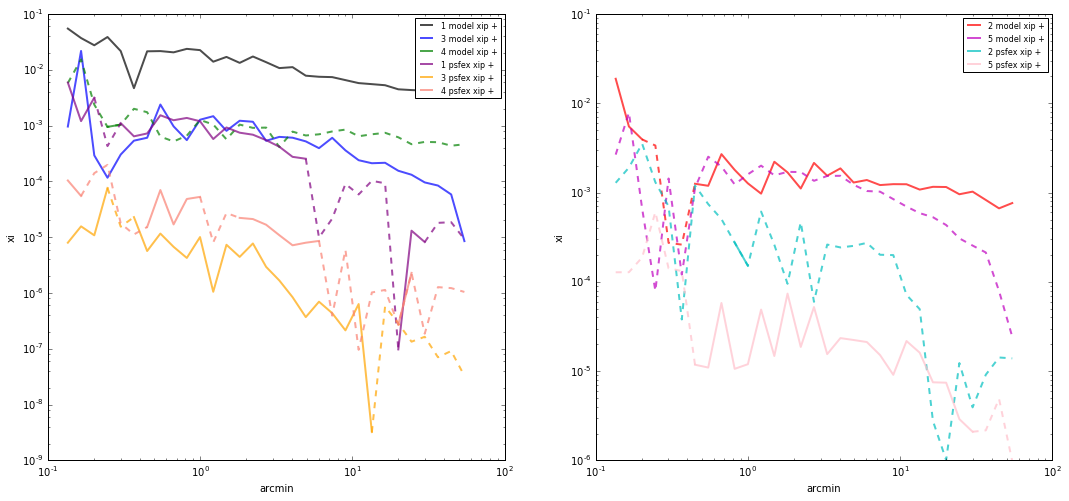

In [67]:
# mm * (pixel / mm) * (arcsec / pixel) * (arcmin / arcsec)
# mmperpixel = 0.015
# arcsecperpixel = 0.27
# arcminperarcsec = 1 / 60
conversion_mm_to_arcmin = (1. / 0.015) * (0.27) * (1. / 60)  # arcmin / mm

psf_name = 'psfex'
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))
rho_names = ['model', 'psfex']
colors = ['k', 'r', 'b', 'g', 'm', 'purple', 'c', 'orange', 'salmon', 'pink', 'olive'] * len(rho_names)
linewidth = 2
alpha = 0.7
for psf_i, psf_name in enumerate(rho_names):
    data = df.copy()
    min_sep=0.1 / conversion_mm_to_arcmin
    max_sep=50 / conversion_mm_to_arcmin
    bin_size=0.1 * 2
    e0key2='{0}_e0'.format(psf_name)
    e1key2='{0}_e1'.format(psf_name)
    e2key2='{0}_e2'.format(psf_name)
    
    rhos = WF.rho_statistics(data,
                             e0key2=e0key2, e1key2=e1key2, e2key2=e2key2,
                             min_sep=min_sep, max_sep=max_sep, bin_size=bin_size,
                             verbose=False)
    
    for rho_i, rho in enumerate(rhos, 1):
        if rho_i in [2, 5]:
            ax = axs[1]
        else:
            ax = axs[0]
        xipp, xipm = separate_negative_and_positive_corr(rho.xip)
        if xipp.mask.sum() != xipp.mask.size:
            ax.loglog(np.exp(rho.logr) * conversion_mm_to_arcmin, xipp,
                      color=colors[rho_i - 1 + 5 * psf_i],
                      linestyle='-', linewidth=linewidth, alpha=alpha,
                      label='{0} {1} xip +'.format(rho_i, psf_name))
        if (xipm.mask.sum() != xipm.mask.size) & (xipp.mask.sum() != xipp.mask.size):
            ax.loglog(np.exp(rho.logr) * conversion_mm_to_arcmin, xipm,
                      color=colors[rho_i - 1 + 5 * psf_i], linestyle='--', linewidth=linewidth, alpha=alpha)
        elif (xipm.mask.sum() != xipm.mask.size) & (xipp.mask.sum() == xipp.mask.size):
            ax.loglog(np.exp(rho.logr) * conversion_mm_to_arcmin, xipm,
                      color=colors[rho_i - 1 + 5 * psf_i],
                      linestyle='--', linewidth=linewidth, alpha=alpha,
                      label='{0} {1} xip -'.format(rho_i, psf_name))
    #     ax.semilogy(rho.logr, np.abs(rho.xim), '--', label='{0} xim'.format(rho_i))
    for ax in axs:
        ax.set_xlabel('arcmin')
        ax.set_ylabel('xi')
        ax.legend(loc='upper right', fontsize=8)
#         ax.set_title(psf_name)
    axs[0].set_ylim(1e-9, 1e-1)
    axs[1].set_ylim(1e-6, 1e-1)

star
opt
starminusopt
psfex
SNR_WIN     77.674355
x           54.830037
y          120.047102
ext         43.000000
Name: 25, dtype: float64


<function __main__.view_stars>

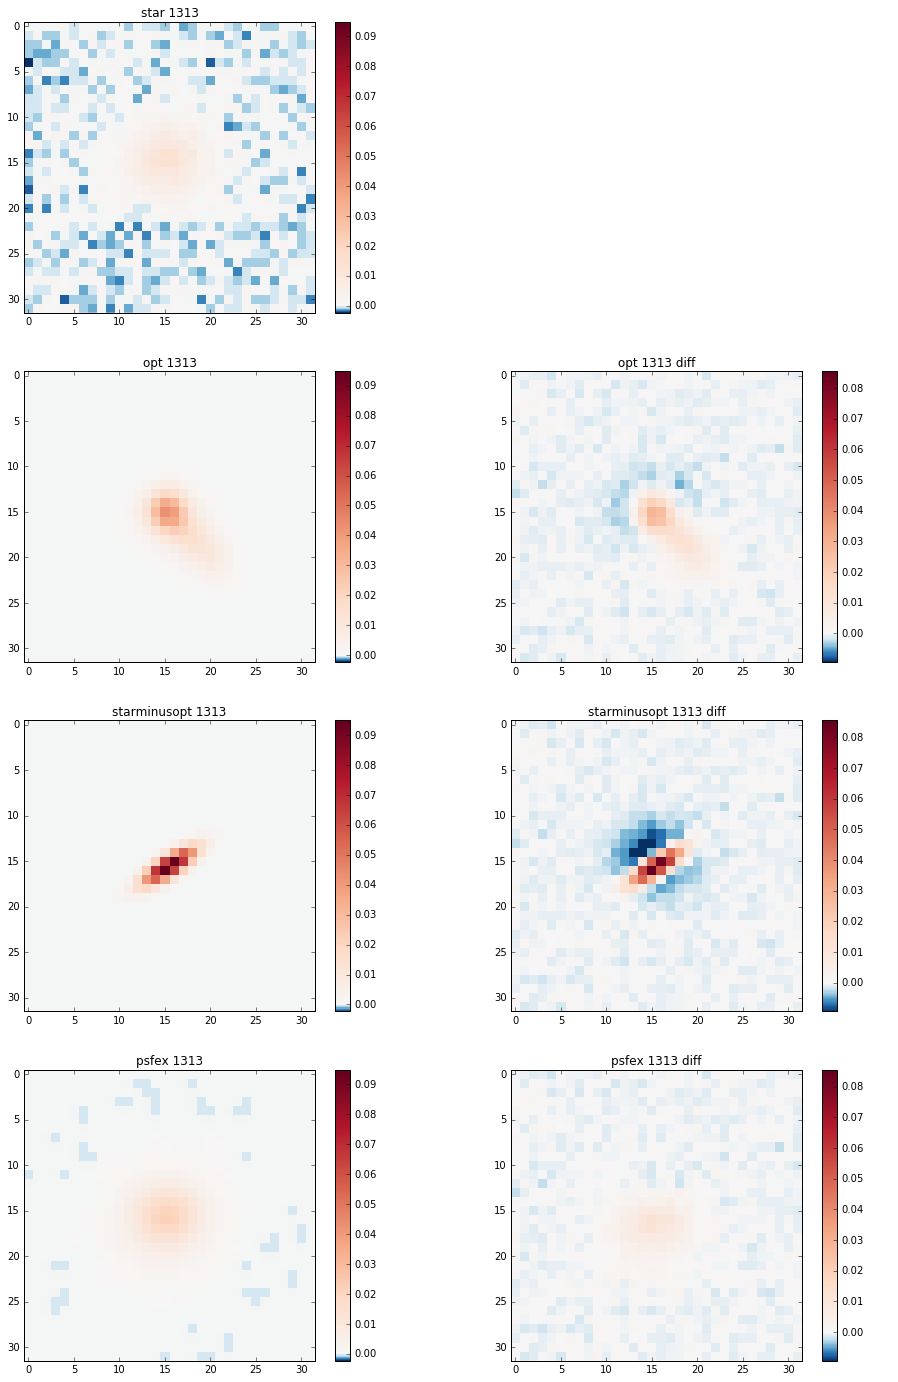

In [68]:
def view_stars(indx=1313):
    #names = ['star', 'model', 'psfex']
    #stamps = [stars, model, psfexpsf]
    #names += ['opt', 'starminusopt', 'atm']
    #stamps += [optpsf, starminusopt, atmpsf]
    names = ['star', 'opt', 'starminusopt', 'psfex']
    stamps = [stars, optpsf, starminusopt, psfexpsf]

    
    nrows = len(names)
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 6 * nrows))
    
    stars_plot = []
    stars_cbar = []
    stars_diff_plot = []
    stars_diff_cbar = []
    for ith, name, stamp in zip(range(len(names)), names, stamps):
        print(name)
        star = stamp[indx].copy()
        if 'starminusopt' == name:
            star = star[15:47, 15:47]
        star = np.where(star < -1e10, 0, star)
        star /= np.abs(star).sum()

        stars_cbar += [star.flatten()]
        stars_plot += [star]
        
        stars_diff_plot.append(star - stars_plot[0])
        if name != 'star':
            stars_diff_cbar.append(stars_diff_plot[-1].flatten())
        
    stars_cbar = np.hstack(stars_cbar)
    stars_diff_cbar = np.hstack(stars_diff_cbar)
    
    
    a = np.percentile(stars_cbar, 0)
    b = np.percentile(stars_cbar, 100)  
    c = 0
    midpoint = (c - a) / (b - a)
    cmap = WF.shiftedColorMap(plt.cm.RdBu_r, midpoint=midpoint)
    
    a_diff = np.percentile(stars_diff_cbar, 0)
    b_diff = np.percentile(stars_diff_cbar, 100)  
    c_diff = 0
    midpoint_diff = (c_diff - a_diff) / (b_diff - a_diff)
    cmap_diff = WF.shiftedColorMap(plt.cm.RdBu_r, midpoint=midpoint_diff)
    
    for ith, name, stamp, stamp_diff in zip(range(len(names)), names, stars_plot, stars_diff_plot):
        ax = axs.flatten()[ith * 2]
        IM = ax.imshow(stamp, cmap=cmap, vmin=a, vmax=b, interpolation='none')
        fig.colorbar(IM, ax=ax)
        ax.set_title('{0} {1}'.format(name, indx))
        
        # plot difference
        ax = axs.flatten()[ith * 2 + 1]
        if name == 'star':
            ax.set_axis_off()
        else:
            IM = ax.imshow(stamp_diff, cmap=cmap_diff, vmin=a_diff, vmax=b_diff, interpolation='none')
            fig.colorbar(IM, ax=ax)
            ax.set_title('{0} {1} diff'.format(name, indx))
    
    keys_view_stars = ['SNR_WIN', 'x', 'y', 'ext']
    print(df_in.iloc[indx][keys_view_stars])
ipywidgets.interact(view_stars, indx=(0, len(df_in), 1))

In [69]:
x = df[df['ext'] == 7].copy()
x[['x', 'y', 'ext', 'atm_e0', 'atm_e1', 'atm_e2']]

,x,y,ext,atm_e0,atm_e1,atm_e2
0,-154.480983,65.792146,7,0.256358,-0.066594,-0.228237
1,-138.192556,67.143449,7,0.181782,-0.023334,-0.148275
2,-142.105717,73.064104,7,0.116457,-0.000032,-0.096918
3,-142.093822,76.274183,7,0.221728,-0.016902,-0.165951
4,-166.724139,79.079426,7,0.140282,-0.046352,-0.114369
5,-156.617295,80.116722,7,0.178831,-0.033157,-0.137462
6,-143.698299,81.054819,7,0.217920,-0.019272,-0.162076
7,-140.832976,81.487613,7,0.235753,-0.024678,-0.165121
8,-151.879118,82.924791,7,0.227905,-0.018662,-0.157323
9,-160.468771,86.961000,7,0.795011,0.001056,0.102023


In [70]:
datadir = '/u/ki/swmclau2/cpdOutput/00%d/'%expid
atm_stars = np.load(datadir+'%d_stars.npy'%expid)
stars_minus_opt_stars = np.load(datadir+'%d_stars_minus_opt.npy'%expid)
stars = np.load(datadir+'%d_stars.npy'%expid)

IOError: [Errno 2] No such file or directory: '/u/ki/swmclau2/cpdOutput/00157930/157930_stars.npy'

In [ ]:
nans = 0
not_nan_idxs = []
for idx, star in enumerate(atm_stars):
    if np.all(np.isnan(star)):
        nans += 1
    else:
        not_nan_idxs.append(idx)
print(nans, atm_stars.shape)
print(not_nan_idxs[0:10])

In [ ]:
x = xrange(atm_stars.shape[0])
y = np.array([np.all(np.isnan(star ) ) for star in atm_stars] )
print(y.shape)
plt.plot(x,y )

In [ ]:
idx = 100
plt.subplot(131)
plt.title("Atm")
plt.imshow(atm_stars[idx])
plt.subplot(132)
plt.title("SMO")
plt.imshow(stars_minus_opt_stars[idx])
plt.subplot(133)
plt.title("Model")
plt.imshow(stars[idx])

In [ ]:
print(stars[idx])